In [1]:
import numpy as np
import time

函数值 
$\|x\|_1+\frac{\sigma}{2}\|Ax-b+\frac{\lambda}{\sigma}\|^2_2$，

可微部分的梯度 $g=\sigma A^\top(Ax-b+\frac{\lambda}{\sigma})$。

In [2]:
opt = {'itr': 20, 'itr_inn': 2500, 'sigma': 1, 
       'tol0': 1e-1, 'gamma': 1, 'verbose': 2}
def prox(x, mu):
    y = np.maximum(abs(x) - mu, 0)
    y = np.multiply(np.sign(x), y)
    #y = np.sign(x) * y
    return y
def BP_ALM(x0, A, b, opts):
    for i in opt.keys():
        if opts.get(i, -1) == -1:
            opts[i] = opt[i]
    sigma = opts['sigma']
    gamma = opts['gamma']
    # 迭代准备
    k = 0
    tt = time.time()
    out = {}
    # 计算并记录初始时刻都约束违反度
    out['feavec'] = np.linalg.norm(np.matmul(A, x0) -b)
    x = x0
    lambda_ = np.zeros(b.shape)
    out['itr_inn'] = 0
    
    # 记录迭代过程的优化变量x的值
    itervec = np.zeros((len(x0), opts['itr'] + 1))
    L = sigma * max(np.linalg.eig(np.matmul(A.T, A))[0])
    # 迭代主循环
    while k < opts['itr']:
        Axb = np.matmul(A, x) - b
        c = Axb + lambda_ / sigma
        g = sigma * np.matmul(A.T, c)
        tmp = 0.5 * sigma * np.linalg.norm(c, 2) ** 2
        f = np.linalg.norm(x, 1) + tmp
        
        nrmG = np.linalg.norm(x - prox(x - g, 1), 2)
        tol_t = opts['tol0'] * (10 ** (-k))
        t = 1 / L
        # 子问题求解的近似点梯度法
        Cval = tmp
        Q = 1 
        k1 = 0
        while k1 < opts['itr_inn'] and nrmG > tol_t:
            gp = g
            xp = x
            x = prox(xp - t * gp, t)
            nls =  1
            while True:
                tmp = 0.5 * sigma * np.linalg.norm(np.matmul(A , x) - b + lambda_ / sigma, 2)**2
                if tmp <= Cval + np.matmul(g.T, x - xp) + 0.5 * sigma / t * np.linalg.norm(x - xp, 2)**2 or nls == 5:
                    break
                t = 0.2 * t
                nls += 1
                x = prox(xp - t * g, t)
            f = tmp + np.linalg.norm(x, 1)
            nrmG = np.linalg.norm(x - xp, 2) / t
            Axb = np.matmul(A, x) - b
            c = Axb + lambda_ / sigma
            g = sigma * np.matmul(A.T, c)
            
            dx = x - xp
            dg = g - gp
            dxg = np.abs(np.matmul(dx.T, dg))
            if dxg > 0:
                if k % 2 == 0:
                    t = np.linalg.norm(dx, 2) **2 / dxg
                else:
                    t = dxg / np.linalg.norm(dg, 2) ** 2
            t = min(max(t, 1 / L), 1e12)
            Qp = Q
            Q = gamma * Qp + 1
            Cval = (gamma * Qp * Cval + tmp) / Q
            k1 += 1
            if opts['verbose'] > 1:
                print('itr_inn: %d\tfval: %e\t nrmG: %e\n'%(k1, f,nrmG))
        if opts['verbose']:
            print('itr_inn: %d\tfval: %e\t nrmG: %e\n'%(k1, f,nrmG))
        lambda_ = lambda_ + sigma * Axb
        k += 1
        out['feavec'] = np.vstack((out['feavec'], np.linalg.norm(Axb)))
        itervec[:, k] = x.flatten()
        out['itr_inn'] += k1
    out['tt'] = time.time() - tt
    out['fval'] = f
    out['itr'] = k
    out['itervec'] = itervec
    return [x, out]
        

## 求解基追踪问题

In [3]:
import random
import numpy as np
import scipy.sparse
random.seed(97006855)

m = 512
n = 1024
A = np.random.randn(m, n)
u = scipy.sparse.rand(n,1,0.1).toarray()
b = np.matmul(A, u)
x0 = np.random.randn(n, 1)

optsp = {}
optsp['verbose'] = 1
optsp['gamma'] = 0.85
optsp['itr'] = 7

In [4]:
[x, out] = BP_ALM(x0, A, b, optsp)
k1 = out['itr']
data1 = out['feavec'][1:k1]
print(x0.shape, out['itervec'][:, 1:k1-1])
tmp = np.hstack((x0, out['itervec'][:, 1:k1])) - np.matmul(u, np.ones((1, k1)))
#tmp = [x0.flatten(), out['itervec'][:, 1:k1]] - np.matmul(u, np.ones((1, k1)))
tmp2 = np.sum(tmp * tmp, axis=0)
data2 = np.sqrt(tmp2)

itr_inn: 1201	fval: 4.980666e+01	 nrmG: 7.680339e-02



/home/xingyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: ComplexWarning: Casting complex values to real discards the imaginary part


itr_inn: 45	fval: 5.008059e+01	 nrmG: 8.903760e-03

itr_inn: 11	fval: 5.008260e+01	 nrmG: 1.836351e-04

itr_inn: 42	fval: 5.008481e+01	 nrmG: 9.455254e-05

itr_inn: 24	fval: 5.008634e+01	 nrmG: 2.533631e-06

itr_inn: 2500	fval: 5.008634e+01	 nrmG: 3.320484e-05

itr_inn: 2500	fval: 5.008634e+01	 nrmG: 1.123464e-06

(1024, 1) [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00]
 ...
 [ 5.11914080e-04  6.85510620e-05  5.93917094e-05  4.34149267e-05
   0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]


In [5]:
out['itervec'][:, 1:k1].shape

(1024, 6)

In [6]:
m = 512
n = 1024
A = np.random.randn(m, n)
u = scipy.sparse.rand(n,1,0.2).toarray()
b = np.matmul(A, u)
x0 = np.random.randn(n, 1)
[x, out] = BP_ALM(x0, A, b, optsp)
k2 = out['itr'] + 1
data3 = out['feavec'][1:k2]
tmp = np.hstack((x0, out['itervec'][:, 1:k2])) - np.matmul(u, np.ones((1, k2)))
tmp2 = np.sum(tmp * tmp, axis=0)
data4 = np.sqrt(tmp2)

itr_inn: 2500	fval: 1.017953e+02	 nrmG: 1.457570e+00



/home/xingyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: ComplexWarning: Casting complex values to real discards the imaginary part


itr_inn: 2441	fval: 1.023337e+02	 nrmG: 9.973101e-03

itr_inn: 239	fval: 1.023505e+02	 nrmG: 9.515894e-04

itr_inn: 235	fval: 1.023512e+02	 nrmG: 9.431317e-05

itr_inn: 2500	fval: 1.023512e+02	 nrmG: 1.650086e-05

itr_inn: 2500	fval: 1.023512e+02	 nrmG: 7.927562e-05

itr_inn: 2500	fval: 1.023512e+02	 nrmG: 2.506406e-06



In [7]:
tmp.shape

(1024, 8)

In [8]:
import matplotlib
 
font = {'family': 'MicroSoft Yahei',
       'weight': 'bold',
       'size': 12}
 
matplotlib.rc("font", **font)

ValueError: x and y must have same first dimension, but have shapes (6,) and (7,)

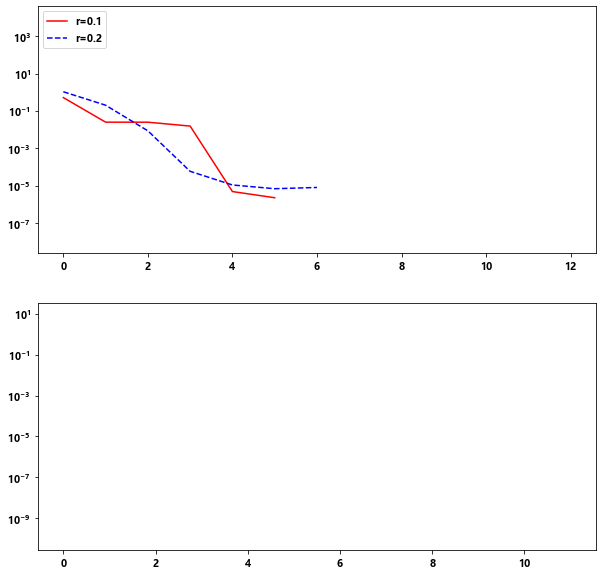

In [9]:
import matplotlib.pyplot as plt
y1=[pow(10,i) for i in range(-8,5)]
x1=range(0, len(y1))
plt.figure(figsize=(10, 10)) 
plt.subplot(2,  1,  1)  
plt.plot(x1, y1, 'white')
plt.yscale('log')
plt.plot(list(range(k1-1)), data1,'-', c='red', label = 'r=0.1')
plt.plot(list(range(k2-1)), data3, '--',c='blue', label='r=0.2')
plt.legend()

plt.subplot(2,  1,  2)
y1=[pow(10,i) for i in range(-10,2)]
x1=range(0, len(y1))
plt.plot(x1, y1, 'white')
plt.yscale('log')
plt.plot(list(range(k1-1)), data2,'-', c='red', label = 'r=0.1')
plt.plot(list(range(k2-1)), data4, '--',c='blue', label='r=0.2')

plt.savefig('罚函数法')